## Pré-processamento

---



*   Corrigir tipos dos dados
*   Apagar coluna de nomes
*   Tornar o data set todo numérico



In [0]:
#get file
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving SiSU.csv to SiSU (1).csv
User uploaded file "SiSU.csv" with length 2133986 bytes


In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!apt-get install swig -y
!pip uninstall auto-sklearn -y
!pip install Cython

In [0]:
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install

In [0]:
!pip install auto-sklearn

In [0]:
!pip install -U scikit-learn==0.19.2

In [0]:
!pip install tpot

In [0]:
import csv
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix, r2_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, train_test_split
from tpot import TPOTRegressor
import seaborn as sns; sns.set()

In [0]:
# tornar o experimento reproduzível
seed_value = 56

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [0]:
dfSiSU_raw = pd.read_csv('SiSU.csv', encoding = 'utf-8')
dfSiSU_raw = dfSiSU_raw.drop(columns = 'Unnamed: 0')

In [0]:
dfSiSU_raw = dfSiSU_raw.drop(columns='NOME')
dfSiSU_raw.head()

,NOTA,CURSO,ANO,COTISTA,BAIXA_RENDA,DEFICIENCIA,RACA,SEXO
0,685.37,ABI - ENGENHARIA,2016,True,False,False,PRETO/PARDO/INDIGENA,NaN
1,716.03,ABI - ENGENHARIA,2016,False,False,False,BRANCO,Male
2,659.49,ABI - ENGENHARIA,2016,True,False,False,PRETO/PARDO/INDIGENA,Female
3,648.32,ABI - ENGENHARIA,2016,True,False,False,PRETO/PARDO/INDIGENA,Male
4,695.95,ABI - ENGENHARIA,2016,False,False,False,BRANCO,Male


In [0]:
dfSiSU_raw.CURSO = dfSiSU_raw.CURSO.astype('category')
dfSiSU_raw.SEXO = dfSiSU_raw.SEXO.astype('category')
dfSiSU_raw.RACA = dfSiSU_raw.RACA.astype('category')
dfSiSU_raw.dtypes

NOTA            float64
CURSO          category
ANO               int64
COTISTA            bool
BAIXA_RENDA        bool
DEFICIENCIA        bool
RACA           category
SEXO           category
dtype: object

In [0]:
# Tornando o data set todo numérico

dfSiSU_raw['SEXO'] = dfSiSU_raw['SEXO'].cat.codes
dfSiSU_raw['CURSO'] = dfSiSU_raw['CURSO'].cat.codes
dfSiSU_raw['RACA'] = dfSiSU_raw['RACA'].cat.codes

sexDummies = pd.get_dummies(dfSiSU_raw['SEXO'], prefix = 'SEXO')
courseDummies = pd.get_dummies(dfSiSU_raw['CURSO'], prefix = 'CURSO')
raceDummies = pd.get_dummies(dfSiSU_raw['RACA'], prefix = 'RACA')

dfSiSU_raw = pd.concat([dfSiSU_raw, sexDummies], axis=1)
dfSiSU_raw = pd.concat([dfSiSU_raw, courseDummies], axis=1)
dfSiSU_raw = pd.concat([dfSiSU_raw, raceDummies], axis=1)

dfSiSU_raw = dfSiSU_raw.drop('SEXO', 1)
dfSiSU_raw = dfSiSU_raw.drop('CURSO', 1)
dfSiSU_raw = dfSiSU_raw.drop('RACA', 1)

dfSiSU_raw.head()

,NOTA,ANO,COTISTA,BAIXA_RENDA,DEFICIENCIA,SEXO_-1,SEXO_0,SEXO_1,CURSO_0,CURSO_1,...,CURSO_52,CURSO_53,CURSO_54,CURSO_55,CURSO_56,CURSO_57,CURSO_58,CURSO_59,RACA_0,RACA_1
0,685.37,2016,True,False,False,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,716.03,2016,False,False,False,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,659.49,2016,True,False,False,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,648.32,2016,True,False,False,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,695.95,2016,False,False,False,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [0]:
X = dfSiSU_raw.drop('NOTA', axis=1)
y = dfSiSU_raw.NOTA

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed_value)

# Regressão

---

*NOTA* foi a coluna escolhida para inferência de valor. Como trata-se de um valor contínuo, o conceito de regressão será aplicado.

**Regressão**: ferramenta de aprendizagem de máquina que tenta prever algum tipo de resultado contínuo, portanto é a escolhida quando a variável dependente (rótulo) é contínua.

Algoritmos escolhidos:


1.   Random Forest
2.   Linear Regression
3.   Extra Tree Regressor
4.   KNN



Métricas de avaliação escolhidas:


1.   R2 (R-Squared): Quão bem as variáveis independentes selecionadas explicam a variabilidade da variável dependente.
2.   MSE (Mean Squared Error): A média, ao quadrado, da diferença entre os valores reais e os preditos pelo modelo.


### Random Forest

O primeiro algoritmo escolhido foi o *Random Forest,* pois é o mais recomendado por diversos especialistas como ponto de partida, já que geralmente possui um bom desempenho para "qualquer" conjunto de dados.

CPU times: user 1.08 s, sys: 13.2 ms, total: 1.1 s
Wall time: 670 ms
R2:   0.860
MSE:   399.179


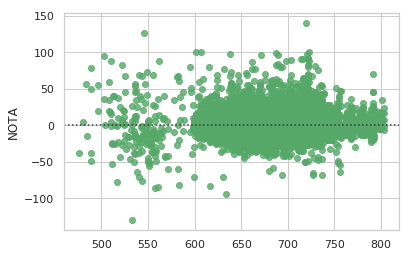

In [0]:
model_rf = RandomForestRegressor(n_jobs=-1, random_state=seed_value)
%time model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("R2:   {:.3f}".format(r2_rf))
print("MSE:   {:.3f}".format(mse_rf))

sns.set(style="whitegrid")
sns.residplot(y_pred_rf, y_test, color="g")

In [0]:
#grid search

grid_param = {  
    'n_estimators': [10, 32, 64, 100],
    'max_depth': [None, 5, 10],
    'max_features': ['auto', 'sqrt']
}

gd_sr_rf = GridSearchCV(estimator=model_rf, param_grid=grid_param, n_jobs=-1)

gd_sr_rf.fit(X_train, y_train)  

y_pred_rf_grid = gd_sr_rf.predict(X_test) 

r2_rf_grid = r2_score(y_test, y_pred_rf_grid)
mse_rf_grid = mean_squared_error(y_test, y_pred_rf_grid)

print("R2:   {:.3f}".format(r2_rf_grid))
print("MSE:   {:.3f}".format(mse_rf_grid))

R2:   0.861
MSE:   397.047


### Linear Regression

Uma simples utilização da regressão linear para demonstrar o quanto Random Forest básico consegue ser bem superior.

CPU times: user 145 ms, sys: 21 ms, total: 165 ms
Wall time: 127 ms
R2:   0.8207845
MSE:   511.956


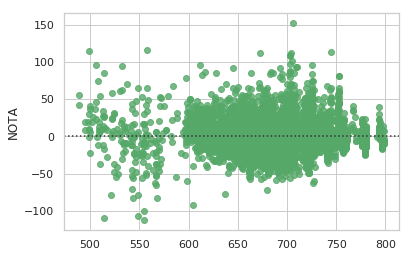

In [0]:
model_lr = LinearRegression(n_jobs=-1)
%time model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print("R2:   {:.7f}".format(r2_lr))
print("MSE:   {:.3f}".format(mse_lr))

sns.set(style="whitegrid")
sns.residplot(y_pred_lr, y_test, color="g")

In [0]:
#grid search

grid_param = {  
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]
}

gd_sr_lr = GridSearchCV(estimator=model_lr, param_grid=grid_param, n_jobs=-1)

gd_sr_lr.fit(X_train, y_train)  

y_pred_lr_grid = gd_sr_lr.predict(X_test) 

r2_lr_grid = r2_score(y_test, y_pred_lr_grid)
mse_lr_grid = mean_squared_error(y_test, y_pred_lr_grid)

print("R2:   {:.7f}".format(r2_lr_grid))
print("MSE:   {:.3f}".format(mse_lr_grid))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


R2:   0.8207852
MSE:   511.954


### Extra Tree

O algoritmo do Scikit learn chamado *Extra Trees Regressor*(**ext**remely **ra**ndomized **trees**) usa árvores de decisão randômicas em várias amostras do dataset e, por meio de médias, melhora a acurácia da predição e controla overfitting.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1.77 s, sys: 57.2 ms, total: 1.83 s
Wall time: 978 ms
R2:   0.848
MSE:   432.945


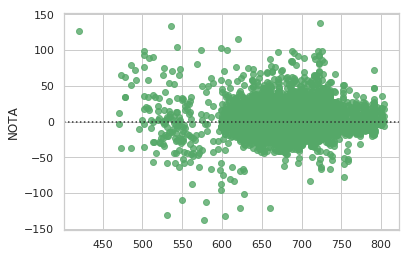

In [0]:
model_etr = ExtraTreesRegressor(n_jobs=-1, random_state=seed_value)
%time model_etr.fit(X_train, y_train)

y_pred_etr = model_etr.predict(X_test)

r2_etr = r2_score(y_test, y_pred_etr)
mse_etr = mean_squared_error(y_test, y_pred_etr)

print("R2:   {:.3f}".format(r2_etr))
print("MSE:   {:.3f}".format(mse_etr))

sns.set(style="whitegrid")
sns.residplot(y_pred_etr, y_test, color="g")

In [0]:
#grid search

grid_param = {  
    'n_estimators': [10, 32, 64, 100],
    'max_depth': [None, 5, 10],
    'max_features': ['auto', 'sqrt'],
}

gd_sr_etr = GridSearchCV(estimator=model_etr, param_grid=grid_param, n_jobs=-1)

gd_sr_etr.fit(X_train, y_train)  

y_pred_etr_grid = gd_sr_etr.predict(X_test) 

r2_etr_grid = r2_score(y_test, y_pred_etr_grid)
mse_etr_grid = mean_squared_error(y_test, y_pred_etr_grid)

print("R2:   {:.3f}".format(r2_etr_grid))
print("MSE:   {:.3f}".format(mse_etr_grid))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


R2:   0.856
MSE:   410.605


### KNN

K Nearest Neighbors é um algoritmo simples que prediz baseando-se numa métrica de similaridade, por exemplo funções de distância como a euclidiana.

CPU times: user 181 ms, sys: 12 ms, total: 193 ms
Wall time: 195 ms
R2:   0.793
MSE:   591.667


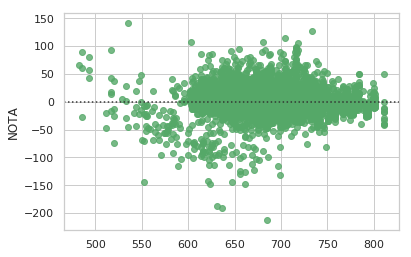

In [0]:
model_knn = KNeighborsRegressor(n_jobs=-1)
%time model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

r2_knn = r2_score(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)

print("R2:   {:.3f}".format(r2_knn))
print("MSE:   {:.3f}".format(mse_knn))

sns.set(style="whitegrid")
sns.residplot(y_pred_knn, y_test, color="g")

In [0]:
#grid search

grid_param = {  
    'n_neighbors': [3, 4, 5, 6, 7, 8, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

gd_sr_knn = GridSearchCV(estimator=model_knn, param_grid=grid_param, n_jobs=-1)

gd_sr_knn.fit(X_train, y_train)  

y_pred_knn_grid = gd_sr_knn.predict(X_test) 

r2_knn_grid = r2_score(y_test, y_pred_knn_grid)
mse_knn_grid = mean_squared_error(y_test, y_pred_knn_grid)

print("R2:   {:.3f}".format(r2_knn_grid))
print("MSE:   {:.3f}".format(mse_knn_grid))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


R2:   0.819
MSE:   515.915


### Auto-Sklearn

O Auto-Sklearn procura pelo melhor algoritmo para machine learning, entre aqueles implementados no scikit-learn, e otimiza seus hiper parâmetros.

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-06-12 19:08:18,309:AutoMLSMBO(56)::61c2e5a0b35cf96da1db53d8bf31cc8b] Could not find meta-data directory /usr/local/lib/python3.6/dist-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-06-12 19:08:18,334:EnsembleBuilder(56):61c2e5a0b35cf96da1db53d8bf31cc8b] No models better than random - using Dummy Score!
[WARNING] [2019-06-12 19:08:18,358:EnsembleBuilder(56):61c2e5a0b35cf96da1db53d8bf31cc8b] No models better than random - using Dummy Score!
[WARNING] [2019-06-12 19:08:20,379:EnsembleBuilder(56):61c2e5a0b35cf96da1db53d8bf31cc8b] No models better than random - using Dummy Score!
[WARNING] [2019-06-12 19:08:22,397:EnsembleBuilder(56):61c2e5a0b35cf96da1db53d8bf31cc8b] No models better than random - using Dummy Score!
[WARNING] [2019-06-12 19:08:24,402:EnsembleBuilder(56):61c2e5a0b35cf96da1db53d8bf31cc8b] No models better than random - using Dummy Score!


/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty

56
['/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000000.ensemble', '/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000001.ensemble', '/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000002.ensemble', '/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000003.ensemble', '/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000004.ensemble', '/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000005.ensemble', '/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000006.ensemble', '/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000007.ensemble', '/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000008.ensemble', '/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000009.ensemble', '/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000010.ensemble', '/tmp/autosklearn_tmp_2092_6138/.auto-sklearn/ensembles/56.0000000011.ensemble', '/tmp/autosklearn_tmp_20

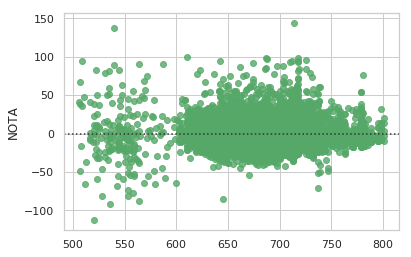

In [0]:
import autosklearn.regression

model_auto_all = autosklearn.regression.AutoSklearnRegressor(seed=seed_value)
model_auto_all.fit(X_train, y_train)

y_pred_auto_all = model_auto_all.predict(X_test)

r2_auto_all = r2_score(y_test, y_pred_auto_all)
mse_auto_all = mean_squared_error(y_test, y_pred_auto_all)

print("R2:   {:.3f}".format(r2_auto_all))
print("MSE:   {:.3f}".format(mse_auto_all))

sns.set(style="whitegrid")
sns.residplot(y_pred_auto_all, y_test, color="g")

R2:   0.864

MSE:   389.035

In [0]:
# Procurando o melhor modelo usando RandomForest

import autosklearn.regression

model_auto = autosklearn.regression.AutoSklearnRegressor(seed=seed_value, include_estimators=["random_forest", ])
model_auto.fit(X_train, y_train)

y_pred_auto = model_auto.predict(X_test)

r2_auto = r2_score(y_test, y_pred_auto)
mse_auto = mean_squared_error(y_test, y_pred_auto)

print("R2:   {:.3f}".format(r2_auto))
print("MSE:   {:.3f}".format(mse_auto))

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-06-12 18:08:21,603:AutoMLSMBO(56)::61c2e5a0b35cf96da1db53d8bf31cc8b] Could not find meta-data directory /usr/local/lib/python3.6/dist-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-06-12 18:08:21,620:EnsembleBuilder(56):61c2e5a0b35cf96da1db53d8bf31cc8b] No models better than random - using Dummy Score!
[WARNING] [2019-06-12 18:08:21,641:EnsembleBuilder(56):61c2e5a0b35cf96da1db53d8bf31cc8b] No models better than random - using Dummy Score!
[WARNING] [2019-06-12 18:08:23,645:EnsembleBuilder(56):61c2e5a0b35cf96da1db53d8bf31cc8b] No models better than random - using Dummy Score!
[WARNING] [2019-06-12 18:08:25,660:EnsembleBuilder(56):61c2e5a0b35cf96da1db53d8bf31cc8b] No models better than random - using Dummy Score!
[WARNING] [2019-06-12 18:08:27,674:EnsembleBuilder(56):61c2e5a0b35cf96da1db53d8bf31cc8b] No models better than random - using Dummy Score!


/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty

[WARNING] [2019-06-12 18:38:29,658:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-06-12 18:38:29,658:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty

56
['/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000000.ensemble', '/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000001.ensemble', '/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000002.ensemble', '/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000003.ensemble', '/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000004.ensemble', '/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000005.ensemble', '/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000006.ensemble', '/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000007.ensemble', '/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000008.ensemble', '/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000009.ensemble', '/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000010.ensemble', '/tmp/autosklearn_tmp_2092_1548/.auto-sklearn/ensembles/56.0000000011.ensemble', '/tmp/autosklearn_tmp_20

R2:   0.862

MSE:   393.965

O **auto-sklearn** foi utilizado de duas formas diferentes, a primeira rodando sem restrição e a segunda focado no algoritmo *RandomForest*.


A primeira forma aumentou o desempenho no conjunto de teste em 0.3%. Na segunda o aumento foi ainda menor, de apenas 0.1%.

In [0]:
y_pred_auto_all_train = model_auto_all.predict(X_train)
y_pred_auto_train = model_auto.predict(X_train)

r2_auto_all_train = r2_score(y_train, y_pred_auto_all_train)
r2_auto_train = r2_score(y_train, y_pred_auto_train)


print("R2 TRAIN (sem restrição):   {:.3f}".format(r2_auto_all_train))
print("R2 TRAIN (somente RandomForest):   {:.3f}".format(r2_auto_train))

R2 TRAIN (sem restrição):   0.884
R2 TRAIN (somente RandomForest):   0.885


### Comparação entre os 4 algoritmos

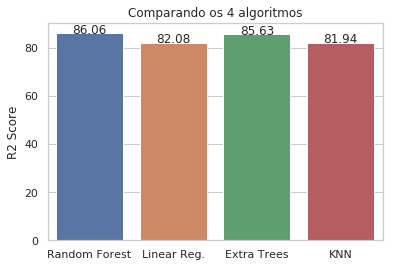

In [0]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

data = {'ALGORITHM': ['Random Forest', 'Linear Reg.', 'Extra Trees', 'KNN'],
       'SCORE': [r2_rf_grid*100, r2_lr_grid*100, r2_etr_grid*100, r2_knn_grid*100]}

dfData = pd.DataFrame(data=data)
ax = sns.barplot(x="ALGORITHM", y="SCORE", data=dfData)

ax.set_title("Comparando os 4 algoritmos")
ax.set_ylabel("R2 Score")
ax.set_xlabel('')
show_values_on_bars(ax)

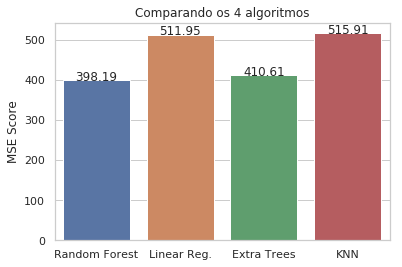

In [0]:
data = {'ALGORITHM': ['Random Forest', 'Linear Reg.', 'Extra Trees', 'KNN'],
       'SCORE': [mse_rf_grid, mse_lr_grid, mse_etr_grid, mse_knn_grid]}

dfData = pd.DataFrame(data=data)
ax = sns.barplot(x="ALGORITHM", y="SCORE", data=dfData)

ax.set_title("Comparando os 4 algoritmos")
ax.set_ylabel("MSE Score")
ax.set_xlabel('')
show_values_on_bars(ax)

## Diagnóstico do modelo


---

_Random Forest_ foi o algoritmo escolhido, já que obteve os melhores scores na avaliação preliminar, com maior R2 e menor MSE.

In [0]:
y_pred_test_rf = gd_sr_rf.predict(X_test)
y_pred_train_rf = gd_sr_rf.predict(X_train)

In [0]:
r2_train = r2_score(y_train, y_pred_train_rf)
r2_test = r2_score(y_test, y_pred_test_rf)

target = 3
bias = (100-(r2_train*100)-target)
variance = abs((r2_train-r2_test)*100)

print("R2 TRAINING: {:.3f}".format(r2_train))
print("R2 TEST: {:.3f}\n".format(r2_test))

print("Erro no treinamento: {:.2f}%".format(100-(r2_train*100)))
print("Erro no teste: {:.2f}%\n".format(100-(r2_test*100)))

print(f"Alvo: {target}% de erro")
print("Viés: {:.2f}%".format(bias))
print("Variância: {:.2f}%\n".format(variance))


# print("MSE TRAINING: {:.3f}".format(mean_squared_error(y_train, y_pred_train_rf)))
# print("MSE TEST: {:.3f}".format(mean_squared_error(y_test, y_pred_rf)))

R2 TRAINING: 0.903
R2 TEST: 0.861

Erro no treinamento: 9.74%
Erro no teste: 13.90%

Alvo: 3% de erro
Viés: 6.74%
Variância: 4.16%



Ao comparar o desempenho do modelo nos conjuntos de treinamento e de teste, notou-se a necessidade de melhorar o desempenho no conjunto de treinamento. Pela análise entre as porcentagens de erro o viés torna-se expressivo quando o alvo de erro é menor que 5%, enquanto que a variância é relativamente baixa. Dessa forma, há indícios de ***underfitting***.


> Algumas técnicas para lidar com *underfitting* são:
*   Aumentar complexidade do modelo
*   Utilizar mais features
  
   
   
Como adicionar mais dados ao conjunto de treinamento **NÃO** ajuda e todas as features do dataset já estão sendo utilizadas, o que será realizado para melhorar o modelo é o **aumento da complexidade**.



In [0]:
gd_sr_rf.best_params_

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

In [0]:
grid_param = {  
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 32, 64],
    'max_features': ['auto', 'sqrt']
#     'min_samples_leaf': [1, 3, 5, 10, 25],
#     'min_samples_split': [0.5, 1.0, 2],
}

gd_sr = GridSearchCV(estimator=gd_sr_rf.best_estimator_, param_grid=grid_param, n_jobs=-1)

gd_sr.fit(X_train, y_train)  

y_pred_train_rf = gd_sr.predict(X_train) 
y_pred_rf = gd_sr.predict(X_test)

r2_rf_gd = r2_score(y_train, y_pred_train_rf)
r2_rf_gd_test = r2_score(y_test, y_pred_rf)

print("R2 TRAINING:   {:.3f}".format(r2_rf_gd))
print("R2 TEST:   {:.3f}".format(r2_rf_gd_test))
gd_sr.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worke

R2 TRAINING:   0.903
R2 TEST:   0.861


{'max_depth': 64, 'max_features': 'sqrt', 'n_estimators': 500}

### Usando TPOT

Após a realização do diagnóstico do modelo e posterior tentativa de melhoria, conclui-se que ele já chegou ao *limite superior*, pois tornar o modelo mais complexo não melhorou seu desempenho no conjunto de treinamento. 

O **TPOT** foi utilizado como uma tentativa mais exaustiva de encontrar um modelo com melhor desempenho, porém o encontrado melhora em apenas 0.7% no conjunto de teste e penaliza o de treinamento, caindo 0.5%. 

In [0]:
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(X_train, y_train)

y_pred_tpot_train = tpot.predict(X_train)
y_pred_tpot_test = tpot.predict(X_test)

r2_tpot_train = r2_score(y_train, y_pred_tpot_train)
r2_tpot_test = r2_score(y_test, y_pred_tpot_test)

print("R2 TRAINING:   {:.3f}".format(r2_tpot_train))
print("R2 TEST:   {:.3f}".format(r2_tpot_test))

Generation 1 - Current best internal CV score: -377.8550171862861
Generation 2 - Current best internal CV score: -377.7059933181441
Generation 3 - Current best internal CV score: -377.7059933181441
Generation 4 - Current best internal CV score: -377.7059933181441
Generation 5 - Current best internal CV score: -377.7059933181441

Best pipeline: ExtraTreesRegressor(RidgeCV(input_matrix), bootstrap=True, max_features=0.7, min_samples_leaf=1, min_samples_split=8, n_estimators=100)
R2 TRAINING:   0.898
R2 TEST:   0.868


## Referências

---

**Regressão**
*   [Material de aula](https://if1015-datascience.github.io/material/pages/slides.html)
*   [Vídeo aulas do Fast.ai](https://course18.fast.ai/ml.html)

**Experimento reproduzível**

*   [Properly Setting the Random Seed in ML Experiments](https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752)
*   [StackOverflow](https://stackoverflow.com/questions/31057197/should-i-use-random-seed-or-numpy-random-seed-to-control-random-number-gener)

**Random Forest**

*   [Documentação](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
*   [Vídeo aulas do Fast.ai](https://course18.fast.ai/ml.html)
*   [Random Forests and the Bias-Variance Tradeoff](https://towardsdatascience.com/random-forests-and-the-bias-variance-tradeoff-3b77fee339b4)
*    [In Depth: Parameter tuning for Random Forest](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d)
  
**Grid search e cross-validation**

*   [Documentação scikit-learn](https://scikit-learn.org/stable/modules/grid_search.html)
*   [Grid Search for model tuning](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)
*   [Cross Validation and Grid Search for Model Selection in Python](https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/)

**Auto-sklearn**
*    [Introduction to Auto-Sklearn](https://www.simonwenkel.com/2018/09/09/Introduction-to-auto-sklearn.html)
*    [Colab Example](https://colab.research.google.com/drive/1Au5sGCegoGLLxqrIs85GCCW0oWIHqwQw#scrollTo=nlaiS3Ouq9Tm)

**Métricas de avaliação**
*     [Choosing the Right Metric for Evaluating Machine Learning Models ](https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4)
*     [Evaluation Metrics in Regression Models
](https://pt.coursera.org/lecture/machine-learning-with-python/evaluation-metrics-in-regression-models-5SxtZ)

**TPOT**
*     [Documentação](https://epistasislab.github.io/tpot/)